# The first-order wave equation


## Introduction

For convenience, we start with importing some modules needed below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('../styles/mainstyle.use')

In Chapter 2 and 3 of this course, we described respectively the time integration of ordinary differential equations and the discretization of differential operators using finite difference formulas.

Here we combine these tools to address the numerical solution of partial differential equations. We mainly focus on the first-order wave equation (all symbols are properly defined in the corresponding sections of the notebooks),

```{math}
:label: eq:advection
   \frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x}=0,
```

and the heat equation,

```{math}
   \partial_t T(x,t) = \alpha \frac{d^2 T} {dx^2}(x,t) + \sigma (x,t).
```

To solve these equations we will transform them into systems of coupled ordinary differential equations using a semi-discretization technique. In that framework, our model equations are approximated as,

```{math}
:label: eq:semiDiscrete
    \frac{du_i}{dt}=f_i (u_0, u_1, \ldots, u_{nx-1}), \; \; i=0,\ldots, nx-1
```

To achieve this, we need to choose a time integration scheme for the left-hand side *and* a spatial discretization scheme for the right-hand side. The combination of these two choices determines the success or failure of the whole numerical method. 

As usual, we need to introduce a grid and grid points at which we evaluate our physical quantities. We consider again a uniform grid consisting of $nx$ grid points with coordinates,

```{math}
 x_i = i \Delta x, \; \; 0\leq i \leq nx-1
```

where $\Delta x$ is the grid spacing.

For the time integration scheme we use a constant time step $dt$ so that all the intermediate times at which we compute our variables are,

```{math}
 t^n = t_0 + n dt, \; \; 0\leq n \leq nt.
```

The discrete quantities we want to evaluate are therefore,

```{math}
u^n_i = u(x_i, t^n).
```

But before we start digging into the theory and show some examples, we introduce below the concept of Python modules.

## Python modules

Up to now, we have always written all the necessary Python code parts for our examples and test cases inside each notebooks. This has the advantage of making all the necessary statements and steps visible to the reader. But in the long run, this approach also has its limitations. For example, if we need a function to compute the first-order derivative, we need to define it in each notebook and this is a repetitive task. Gladly, Python allows to overcome this through the use of *modules*.

From the official Python documentation: 

> [A module][21] is a file containing Python definitions and statements. The file name is the module name with the suffix .py appended.

A Python module may contain any Python code. This code can then be imported into your main program or other modules. In fact, we have already used modules. When writing,

> `from scipy.linalg import inv`

we are *importing* the `inv` function, defined in the module `scipy.linalg` to make it available in our notebook. This is very convenient, we don't need to copy/paste the Python code contained in the `inv` function to use it.

So let us create our first module. If you look into the directory in which this notebook is stored on your computer, you will notice a file called `test_module.py`. Take a look at this file now. Its content is reproduced here:

```python
import numpy as np

def triangle_area(base, height):
    """Returns the area of a triangle
    Parameters
    ----------
    base : float
        length of the triangle's base
    height : function
        height of the triangle

    Returns
    -------
    area : float
        area of the triangle
    """
    area = 0.5*base*height
    return area

def twos(shape):
    """Returns a 1D array filled with the value 2
    Parameters
    ----------
    shape : integer
        size requested for the output vector

    Returns
    -------
    myarray : numpy 1D array
        array of size shape, filled with the value 2
    """
    myarray = 2.*np.ones(shape)
    return myarray

```

[21]: <https://docs.python.org/3/tutorial/modules.html> "Modules documentation"

It contains the definition of two functions. Notice how we import `numpy` at the beginning of the file. Without this import, the second function would not work.

To use the function `triangle_area` in the current notebook, we need to import it using:

In [2]:
from test_module import triangle_area

The function can then be called as usual:

In [3]:
area = triangle_area(4, 3)

print(f'The area of the triangle is: {area}.')

The area of the triangle is: 6.0.


At this stage we may not yet use the function `two` because it has not been imported. If it's needed, we may type

In [4]:
from test_module import twos

and use it afterwards:

In [5]:
a = twos(4)
print(a)

[2. 2. 2. 2.]


When more than one item of a module are needed, we can import several or all of them at the same time. Here are different ways to do this:

In [6]:
# Imports the functions separated by a comma
from test_module import triangle_area, twos

# Import every item contained in test_module
from test_module import *

# Import all of test_module and make its content 
# available by using its name followed by a dot.
# Sample usage would be: test_module.twos(4)
import test_module

# Import all of test_module and create a nickname
# to use its content.
# Sample usage would be: tm.twos(4)
import test_module as tm

The choice between the different ways of loading modules is somewhat a matter of taste and often depends on the context (there are plenty of tutorials on the Internet discussing this). For this course, we adopt the following convention:

- For `numpy` we use `import numpy as np` to import the whole content of the package and we use the shortcut `np`.

- For `scipy`, we import the desired functions from the submodules of the package, e.g `from scipy.linalg import inv`

- For our own modules, we use the `from module import item1, item2, ...` construct to be explicit about what we want to import.

If the module file is located in the same folder as your notebook or main program, all the commands described above will work. If not, the module file needs to be located in one of the default search paths of your Python distribution. These paths can be listed by executing the following commands:

```python
import sys
print(path.sys)
```

In a specific notebook, module or program, you may add extra search paths to locate your modules. For this course, we store our custom modules in a folder called *modules*. It is located in the *notebooks* folder. Therefore, its relative path to any notebook is `../modules` (the `..` represents the parent directory). Look now in your local repository and you should see this folder.

To add this path to the default search path, you may run the following cell:

In [7]:
import sys
sys.path.insert(0, '../modules')

Remember that you need to add these lines in all the notebooks in which you want to use the modules located in this folder.

Now that we know how to create and use modules, let's return to the main topic of this chapter: partial differential equations.

## Advection equation

We first consider advection with a constant velocity $c$. This process is described by equation {eq}`eq:advection`. If $u$ is our unknown, the solution to the equation is:

```{math}
u(x,t) = u_0(x-ct),
```

where $u_0(x) = u(x,0)$ is the initial condition. At time $t$, the mathematical solution to the problem is therefore the initial condition shifted by an mount $ct$. To obtain this solution we don't need a computer, so why bother trying to solve it numerically? It turns out that it constitutes a rich and interesting laboratory for developing general methods and analyze their shortcomings.

### Forward Euler, forward finite differentiation

For our first attempt at solving equation {eq}`eq:advection`, we choose the forward Euler method for the time integration and the first-order accurate forward finite difference formula for the derivative.


The discretization then proceeds as follows:

```{math}
\frac{d u^n_i}{dt} &\approx \frac{u^{n+1}_i - u^n_i}{dt}, \; \; \; \frac{\partial u}{\partial x}(x_i, t^n) \approx \frac{u^n_{i+1} - u^n_i}{\Delta x} \\
& \Rightarrow \;
u^{n+1}_i = u^n_i -cdt \frac{u^n_{i+1} - u^n_i}{\Delta x}
```

Note that this discretization is explicit as $u^{n+1}_i$ is directly expressed in terms of quantities known at the previous time step.

For the sake of the example, we solve this equation in the interval $x\in [0, 1]$ with the following initial condition:

```{math}
u(x,0) = e^{-200 (x-0.25)^2}
```

Let us now write a Python code to compute the solution. We first import a function we have defined in our custom module named `steppers`:

In [8]:
from steppers import euler_step

You should now look at the definition of this function and understand what it is doing. You may obtain its documentation by typing:

In [9]:
%pinfo euler_step

In summary, it just performs the operation:

```{math}
u^{n+1}_i = u^n_i + dt f_i(u^n)
```

where $f$ is any function supplied as an argument. If $f$ contains specific parameters, these can be passed to the `euler_step` function as optional arguments. In our case, the function $f$ evaluated at grid point $x_i$ is given by,

```{math}
f_i = -c \frac{u^n_{i+1} - u^n_i}{\Delta x}
```

We still need to choose our boundary conditions. Here the initial condition is nearly equal to zero at the boundaries. As we wont let the wave reach the right boundary (we choose a positive value for $c$), we can safely maintain the conditions $u(x_0,t)=u(x_n,t)=0$ for all times. This can be achieved by setting $f[0]=f[-1]=0$ or by limiting our unkowns to `u[1:-1]`. Here we choose the former option. 

We thus impose Dirichlet boundary conditions, even at the right boundary node where a boundary condition is in principle not required in the original partial differential equation. This is a feature we need to introduce in our numerical solution because we cannot afford a semi-infinite domain.

The desired function $f$ can then be numerically implemented as follows:

In [10]:
def rhs_forward(u, dx, c):
    """Returns the right-hand side of the wave
    equation based on forward finite differences
    
    Parameters
    ----------
    u : array of floats
        solution at the current time-step.
    dx : float
        grid spacing
    c : float
        advection velocity
    
    Returns
    -------
    f : array of floats
        right-hand side of the wave equation with
        boundary conditions implemented (initial values
        of u are kept constant)
    """
    nx = u.shape[0]
    f = np.empty(nx)
    f[1:-1] = -c*(u[2:]-u[1:-1]) / dx
    f[0] = 0
    f[-1] = 0
    
    return f

Parameters for the simulation:

In [11]:
c = 1.        # wave or advection speed
lx = 1.       # length of the computational domain
t_final = 0.2 # final time of for the computation (assuming t0=0)

In [12]:
dt = 0.005                   # time step
nt = int(t_final / dt)       # number of time steps

nx = 101                     # number of grid points 
dx = lx / (nx-1)             # grid spacing
x = np.linspace(0., lx, nx)  # coordinates of grid points

In [13]:
# initial condition
u0 = np.exp(-200 * (x-0.25)**2)

In [14]:
# create an array to store the solution
u = np.empty((nt+1, nx))
# copy the initial condition in the solution array
u[0] = u0.copy()

In [15]:
# perform nt time steps using the forward Euler method
# with first-order forward finite difference
for n in range(nt):
    u[n+1] = euler_step(u[n], rhs_forward, dt, dx, c)

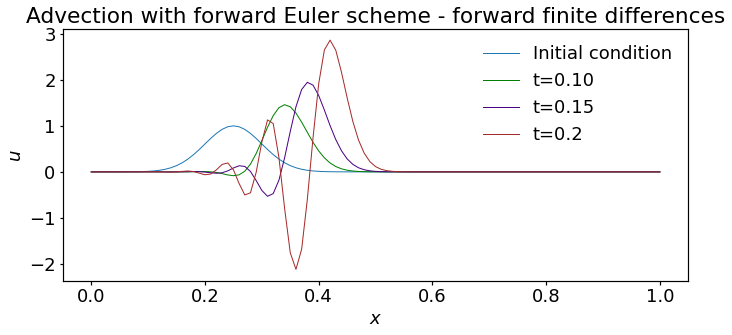

In [16]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, u[0], label='Initial condition')
ax.plot(x, u[int(0.10 / dt)], color='green', label='t=0.10')
ax.plot(x, u[int(0.15 / dt)], color='indigo', label='t=0.15')
ax.plot(x, u[int(t_final / dt)], color='brown', label=f't={t_final}')

ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.set_title('Advection with forward Euler scheme - forward finite differences')
ax.legend();

What is happening ? The solution rapidly deteriorates; it is not peacefully translated at constant wave speed $c$: the maximum increases and some wiggles appear at the trailing edge. If you were to run the simulation just a bit longer, the solution would completely blow up. Try it !

We have already observed such behaviors when discussing integration schemes. We saw that some of them have a limited domain of stability and we should suspect that a similar limitation applies here. We will discuss this point thoroughly in the next notebook. 

Here we just try another numerical scheme to see what happens.

### Forward Euler, backward finite difference differentiation

In this section we replace the forward finite difference scheme with the backward finite difference scheme. The only change we need to make is in the discretization of the right-hand side of the equation. We replace it with the following function (make sure you understand the change):

In [17]:
def rhs_backward(u, dx, c):
    """Returns the right-hand side of the wave
    equation based on backward finite differences
    
    Parameters
    ----------
    u : array of floats
        solution at the current time-step.
    dx : float
        grid spacing
    c : float
        advection velocity
    
    Returns
    -------
    f : array of floats
        right-hand side of the wave equation with
        boundary conditions implemented (initial values
        of u are kept constant)
    """
    nx = u.shape[0]
    f = np.empty(nx)
    f[1:-1] = -c*(u[1:-1]-u[:-2]) / dx
    f[0] = 0
    f[-1] = 0
    
    return f

We can now rerun our simulation with the same parameters.

In [18]:
# create an array to store the solution
u = np.empty((nt+1, nx))
# copy the initial condition in the solution array
u[0] = u0.copy()

In [19]:
# perform nt time steps using the forward Euler method
# with first-order backward finite difference
for n in range(nt):
    u[n+1] = euler_step(u[n], rhs_backward, dt, dx, c)

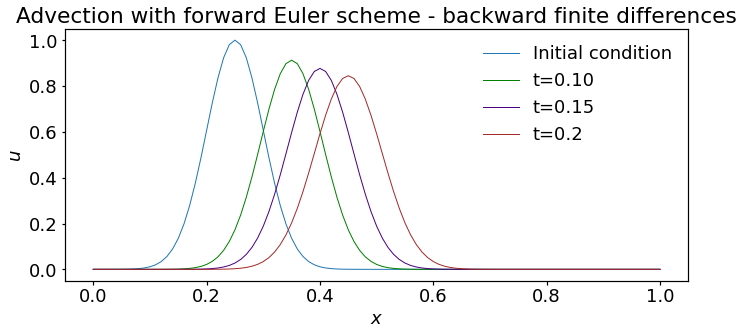

In [20]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, u[0], label='Initial condition')
ax.plot(x, u[int(0.10 / dt)], color='green', label='t=0.10')
ax.plot(x, u[int(0.15 / dt)], color='indigo', label='t=0.15')
ax.plot(x, u[int(t_final / dt)], color='brown', label=f't={t_final}')

ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.set_title('Advection with forward Euler scheme - backward finite differences')
ax.legend();

This time, the solution does not seem to be unstable, but it's still not what we would like: the maximum decreases as the wave is advected and close inspection reveals that the packet widens. By reducing the time step and grid spacing we can however reduce this phenomenon. You should however rerun this version of the discretization with a lager time step, for example $dt=0.05$. What happens in that case?

Before digging more on the stability and accuracy of the numerical schemes used so far, we introduce two other topics: one theoretical (on periodic boundary condition) and one computational (on how to create animations to visualize our simulation results).

## Periodic boundary conditions


### Sample usages

The so-called periodic boundary conditions are used in several types of numerical simulations. Before showing how to implement them for our advection problem, we briefly describe a couple of scenarios.

a) In many physical systems, events occurring in one place only influence what is happening in their vicinity. The distance over which this influence is exerted is called the correlation length. Regions of space separated by a distance much larger than the correlation length are largely independent of each other. Let's take an example. Imagine you want to analyze the dynamics of a spiral arm located in the top-middle galaxy shown in [this image][40]:

<img src='../figures/superspirals.jpg' width="500"/>

Of course, this is a photomontage but we use it to illustrate the discussion. This galaxy is surrounded by other galaxies but they are well separated. If the time scale of interest is short enough compared to the time needed for the galaxies to interact through gravity, what is happening in the spiral arm is not affected by the surrounding galaxies. Therefore, if we simulate the following system instead, the dynamics of the spiral arm should be virtually identical:

<img src="../figures/superspiralsPeriodic.jpg" align="center" width="500">

From the computational point of view, this constitutes a huge advantage. Instead of using a grid that contains the whole system of galaxies, we can focus on one galaxy and artificially extend the grid periodically in all directions. This allows to significantly reduce the number of grid points and make use of efficient algorithms relying on the spatial periodicity of the grid.

b) Certain geometries are intrinsically periodic in some directions. Consider for example the prototype [fusion reactor ITER][41]:

<img src='../figures/iterTorus.png' width="500"/>

The plasma is confined in a toroidal chamber at very high temperature. When modeling this vessel as a torus, two periodic directions naturally appear along the angular directions $\theta$ and $\varphi$. The number of grid points is not reduced by the presence of these periodic directions but one still has the opportunity to discretize them with more efficient numerical algorithms.

c) The final example we mention is of direct interest for the discussion of the wave equation. If we want to track the wave for a long time interval, we need a very long spatial domain. Using a fine numerical grid, this requires a very larger number of grid points. This is costly and inefficient as the wave packet only occupies a fraction of the domain at once. One way around this difficulty is to wrap the domain of propagation around itself. It then becomes a circle and the wave goes round and round around this circle. This is fine as long its circumference is large enough compared to length of the wave packet under consideration. In this setup, the direction of propagation is then periodic.  

[40]: <https://phys.org/news/2019-10-dark-massive-spiral-galaxies-breakneck.html> "phys.org: massive spiral galaxies"
[41]: <https://www.iter.org> "ITER official website"

### Advection in a 1D periodic domain

In this section we show how to simulate the first-order wave equation in a periodic domain. If the propagation direction is denoted $x$ and $L$ is the domain length:

```{math}
    u(x+L) = u(x),\; u'(x+L) = u'(x), \; u''(x+L) = u''(x), \; \hbox{etc.} 
```

As explained above, we must make sure that $L$ is large enough to accommodate the wave packet with enough margin.

Away from the boundaries, we use the backward finite difference scheme for the discretization of the derivative operator and couple it to the forward Euler time integration scheme (we have seen that this combination is stable with an appropriate choice of time step).

In fact, we can also use backward finite differentiation at the right boundary node. Using negative indexing, we may write:

`u^{n+1}[-1] = u^n_i[-1] -cdt (u^n[-1] - u^n[-2])/dx`

At the left boundary node we cannot use this formula directly as there is no point available to the left of this point. However, thanks to the periodicity of the domain, this missing *ghost* point can be associated with the point `x[-2]` as shown in this diagram:

<img width="600px" src="../figures/backwardDiff1periodic.png">

Therefore we may write the derivative at the left boundary node like:

`u^{n+1}[0] = u^n_i[0] -cdt (u^n[0] - u^n[-2])/dx`

As `u[0]=u[-1]` this expression is also equal to the value of $u'$ at the right boundary node. This is expected as the derivative should be periodic.

We are now ready to modify the right-hand side of our discretization and implement the periodic boundary conditions. The definition of the function reads:

In [21]:
def rhs_backward_periodic(u, dx, c):
    """Returns the right-hand side of the wave
    equation based on backward finite differences
    
    Parameters
    ----------
    u : array of floats
        solution at the current time-step.
    dx : float
        grid spacing
    c : float
        advection velocity
    
    Returns
    -------
    f : array of floats
        right-hand side of the wave equation with
        boundary conditions implemented
    """
    nx = u.shape[0]
    f = np.empty(nx)
    f[1:] = -c*(u[1:]-u[0:-1]) / dx
    f[0] = f[-1] # alternatively: f[0] = -c*(u[0]-u[-2]) / dx
    
    return f

We now perform the time stepping. We use the same initial condition as above, but increase the grid resolution to improve the accuracy and limit the diffusion of the wave packet. Also note that we have reduced the time step. The reason for this will become made clear in the next notebook.

In [22]:
t_final = 2. # final time of for the computation (assuming t0=0)
dt = 0.002                   # time step
nt = int(t_final / dt)       # number of time steps

nx = 401                     # number of grid points 
dx = lx / (nx-1)             # grid spacing
x = np.linspace(0., lx, nx)  # coordinates of grid points

In [23]:
# initial condition
u0 = np.exp(-200 * (x-0.25)**2)

# create an array to store the solution
u = np.empty((nt+1, nx))
# copy the initial condition in the solution array
u[0] = u0.copy()

In [24]:
# perform nt time steps using the forward Euler method
# with first-order backward finite difference
for n in range(nt):
    u[n+1] = euler_step(u[n], rhs_backward_periodic, dt, dx, c)

To check our results, let us plot the solution at a time when the wave crosses the right boundary and re-enters the domain through the left boundary:

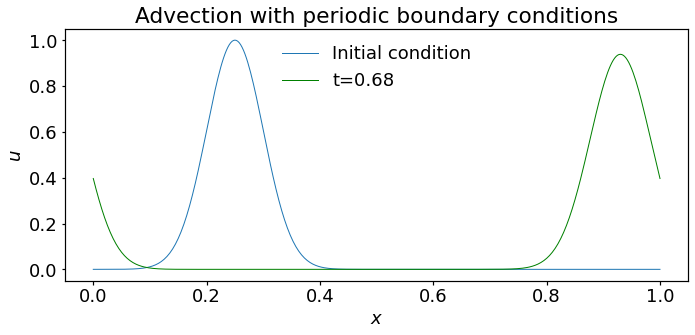

In [25]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, u[0], label='Initial condition')
ax.plot(x, u[int(0.68 / dt)], color='green', label='t=0.68')

ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.set_title('Advection with periodic boundary conditions')
ax.legend();

Quite satisfactorily, the algorithm works as expected !

## Matplotlib animations

Static plots are very useful to display the results of computations. They are used throughout many scientific disciplines. But when the problems considered contain time dependent data, we can often obtain extra insight into the results by creating animations.

Matplotlib contains a (sub-)module designed to do exactly that. It can be imported using the command:

In [26]:
import matplotlib.animation as animation
from IPython.display import HTML

Note that we have also imported the `HTML`module from `IPython.display`. This module is required to display the animations in Jupyter notebooks.

There are two standard ways to create animations. They rely on:

> [matplotlib.animation.FuncAnimation][50] to create an animation by repeatedly calling a function,

or

> [matplotlib.animation.ArtistAnimation][51] to create an animation using a fixed set of Artist objects.

In this notebook we illustrate the usage of `FuncAnimation`. This class is well suited for animating the kind of plots we have been producing so far. By repeatedly calling a function, it updates the content of the plot and stores the successive rendered frames in the animation. We use it below to create an animation of our traveling wave packet. For this course, `ArtistAnimation` is more useful to display simulations results coming out of simulations performed in two dimensions. These typically can be visualized by producing a sequence of images that can then be stitched together to produce the animation. We will document `ArtistAnimation` in a later notebook. 

[50]: <https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.animation.ArtistAnimation.html> "FuncAnimation documentation page"

[51]: <https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.animation.ArtistAnimation.html> "ArtistAnimation documentation page"

To use `FuncAnimation` we first create a plot that contains the data and the elements we want to show in our animation. The main element of this initial frame is the initial condition `u0`:

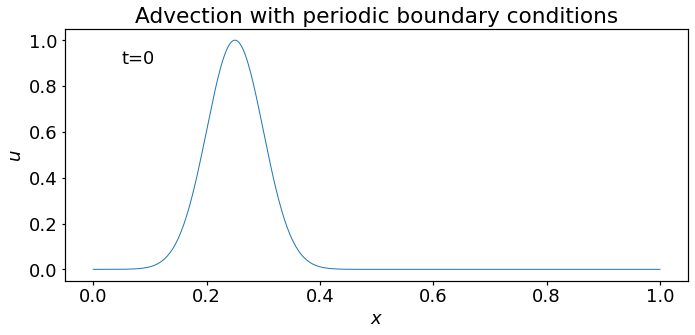

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the initial condition as a function of x
# and indicate the initial time. Note how we store 
# the returned objects in variables. This is essential 
# to later modify those parts of the plot in the
# animation
line, = ax.plot(x, u0)
time_text = ax.text(0.05, 0.9, 't=0')

ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.set_title('Advection with periodic boundary conditions');

Now that we have created our template plot, we need to define a function to tell `FuncAnimation` how to modify it for each frame added to the animation. Here we call this function `animate` but you may give it whatever valid name you want. At minimum, it should contain one argument to indicate the value of an iterator.

Our `animate` function does two things. It updates the line in the plot to show the wave at a given time, and it also changes the text indicating the corresponding time:

In [28]:
def animate(time):
    """Modifies the line representing u and
    the text indicating the corresponding time
    
    Parameters
    ----------
    time : float
        time at which to plot u
    
    Returns
    -------
    line : updated line
    time_text : update text indicating time
    """
    
    # array index corresponding to time
    j = int(time/dt)
    
    # update the line.
    line.set_ydata(u[j])
    
    # update the time text.
    # j*dt is displayed with two digits
    # after the decimal point
    time_text.set_text(f't={time:.2f}')
    
    # return the updated data to FuncAnimation
    return line, time_text

Creating animations can be computationally expensive. Our solution of the wave equation currently contains the profile $u(x)$ at 1001 time steps (including the initial condition). On a Macbook Pro - 2,9 GHz Quad-Core Intel Core i7 - creating an animation that displays all these time steps takes about one minute. When the time needed becomes prohibitively high, it is useful to only include a subset of time steps. Here we want to include every other ten time steps in the animation. To that end, we create a sequence containing the desired time steps:

In [29]:
step = 10 # warning: nt should be a multiple of step
times = np.arange(0, nt+step, step)*dt

We now have all needed ingredients to call `FuncAnimation`. There are many ways to provide the necessary arguments. You should look up the documentation to learn more. Here we pass:

1. the plot to update (fig)
2. the function to call at each frame (animate)
3. the interval in milliseconds  during which each frame should be displayed (interval)
4. an iteratable - frames - containing all the times at which we want to display the velocity
5. a boolean - repeat - specifying that we don't want the animation to loop

In [30]:
# create the animation object
ani = animation.FuncAnimation(
    fig, animate, interval=100, frames=times, repeat=False)

The final step is to display the animation in the notebook. This is done by calling:

In [31]:
HTML(ani.to_jshtml())

Isn't this nice? We observe that our wave packet loops exactly as expected through the periodic domain.

## Summary

In this notebook we have started to discuss the discretization of partial differential equations and introduced the concept of Python modules. 

We took the example of the first-order wave equation and using the technique of semi-discretization we simulated it using the forward Euler method with both forward and backward finite differentiation. The first algorithm proved to be unstable while the second one remained stable for the parameters used.

We also introduced the notion of periodic boundary conditions and discussed some of the situations in which they are useful. 

Finally, we showed how to create animations using `matplotlib.animation.FuncAnimation` to visualize results of time dependent problems.

In the next notebook, we discuss in detail how to determine the stability of the numerical algorithms obtained through semi-discretization.

## Exercises

**Exercise 1:** Using the same parameters as in Section [Section 4.2](#Advection-in-a-1D-periodic-domain), compute the solution of the first order wave equation at $t=0.68$ using the explicit RK4 method for time discretization and second-order centered finite differentiation for the spatial derivative.

*Constraints:*

1. You must use and import the `rk4_step` function provided in the `steppers.py` module file
2. You must implement a function for the right-hand side of {eq}`eq:semiDiscrete` with proper boundary conditions (see above for examples)

- Plot your solution at time $t=0.68$. 

- What is the maximum value of $u$ at that time?

**Exercise 2:** Using the same parameters as in [Section 4.2](#Advection-in-a-1D-periodic-domain), rerun the simulation using the MacCormack method described in Wikipedia: https://en.wikipedia.org/wiki/MacCormack_method. 

- Provide an animation of your solution up to $t=3$.

- What is the maximum value of $u$ at that time?